## TODO: fix raw_has_terms to raw_has_term when we change raw input to has_term in further apps

# Designing and validating confusion matrix reports

Also refer to:  10_1_design_deepdive_sql_reports_for_confusion_matrix. Especially for comments on how we end up with imperfect duplicate inference values for the same input.

## Goal: Use ggplot2 and the caret library to create reports for a confusion matrix for single instances of DeepDive apps. 
## Validating an approach

# Table saved from deepdive contains:

- true unkowns
- knowns
- the knowns duplicated as 'pseudo-unknowns' so they could get predicted whether they were in training or test set.

In [109]:
library(repr)

In [259]:
plot_expect_vs_known_t_f <- function(df, x, y, color, title) {
  require(ggplot2)
  ggplot(df, aes_string(x=x, y=y, color=color)) +
    geom_point(shape=1) + 
    labs(title=paste0('Expect values by article class\n',title),
         x='articles', 
         y='deepdive prediction') +
    theme(plot.title=element_text(size=rel(1)),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank(),
          axis.title=element_text(size=rel(1))) +
    scale_color_discrete(name="Known Class",
                          breaks=c("t", "f"),
                          labels=c("POSITIVE", "NEGATIVE"))
}

get_confusion_matrix <- function(df) {
  # Can check result categories based solely on table...
  #    PPV = TP / (TP + FP)
  #    Sensitivity = TP / (TP + FN)
  #    Specificity = TN / (TN + FP)
  require('caret')
  df$pred_class <- ifelse(df$expect >= 0.5, 'Positive', 'Negative')
  df$known_class <- as.factor(ifelse(df$raw_has_terms == 't', 'Positive', 'Negative'))
  print(levels(df$known_class))
  # will possibly have many cases where we have no negatives
  # want to make sure we don't break confusionMatrix
  if(!'Negative' %in% levels(df$known_class)){
      df$known_class <- factor(df$known_class, levels = c('Negative', levels(df$known_class)))
  }
  # addLevel <- function(x, newlevel=NULL){ if(is.factor(x)) return(factor(x, levels=c(levels(x), newlevel))) return(x) }
  cm = confusionMatrix(df$pred_class, df$known_class, positive='Positive')
  accuracy = cm$overall[c('Accuracy', 'AccuracyLower', 'AccuracyUpper')]
  cm_tab = cm$table
  other_stats = cm$byClass
  stats = c(accuracy, other_stats)
  return(list(table=cm_tab, stats=stats))
}

In [257]:
setwd("/Users/ccarey/Documents/Projects/NAMI/rdoc/tasks/deepdive_app/8_0_3_quick_auditory_perception")
t = read.table('cc_all_predictions.tsv', sep = '\t', col.names=c('test_has_term', 'raw_has_terms', 'sentence_id', 'expect'), na.strings=c('\\N'))

### deepdive results classes based on their known (test and train) or unknown status.
- 1000 known negative for topic
-  146 known positive for topic
- 1000 unknowns, but we should expect many positive predictions because they are similar to our knowns.

## All known labels results

In [202]:
# unique in case we have duplicate records due to predictions on both 
# holdout and pseudolabeled unknowns (see appendix A.2)
# take only the first occurrence. They are all close enough.

all_known <- unique(t[!is.na(t$raw_has_terms), !(names(t) %in% c('test_has_term'))])
all_known <- all_known[!duplicated(all_known$sentence_id),] # 1000 disease + 146 auditory
nrow(all_known)
all_known$index <- row.names(all_known)

all_conf <- get_confusion_matrix(all_known)
all_conf$stats
all_conf$table

[1] 1146

Accuracy        AccuracyLower        AccuracyUpper 
           0.9991274            0.9951479            0.9999779 
         Sensitivity          Specificity       Pos Pred Value 
           0.9931507            1.0000000            1.0000000 
      Neg Pred Value           Prevalence       Detection Rate 
           0.9990010            0.1273997            0.1265271 
Detection Prevalence    Balanced Accuracy 
           0.1265271            0.9965753

          Reference
Prediction Negative Positive
  Negative     1000        1
  Positive        0      145

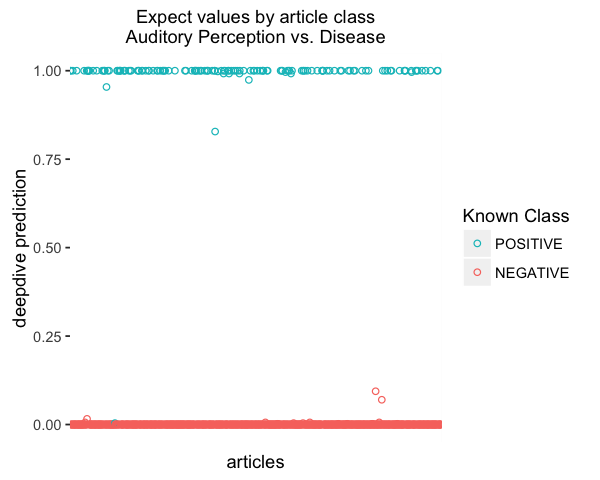

In [174]:
pdf('cc_expect_vs_known.pdf', height=4, width=4)
plot_expect_vs_known_t_f(all_known, 'index', 'expect', 'raw_has_terms', 'Auditory Perception vs. Disease')
dev.off()

plot_expect_vs_known_t_f(all_known, 'index', 'expect', 'raw_has_terms', 'Auditory Perception vs. Disease')

## Holdout results

In [179]:
test <- t[!is.na(t$test_has_term) & !is.na(t$raw_has_terms),]
test <- test[!duplicated(test$sentence_id),]
nrow(test)
test$index <- row.names(test)

test_conf = get_confusion_matrix(test)
test_conf$stats
test_conf$table

[1] 292

Accuracy        AccuracyLower        AccuracyUpper 
           0.9965753            0.9810677            0.9999133 
         Sensitivity          Specificity       Pos Pred Value 
           0.9696970            1.0000000            1.0000000 
      Neg Pred Value           Prevalence       Detection Rate 
           0.9961538            0.1130137            0.1095890 
Detection Prevalence    Balanced Accuracy 
           0.1095890            0.9848485

          Reference
Prediction Negative Positive
  Negative      259        1
  Positive        0       32

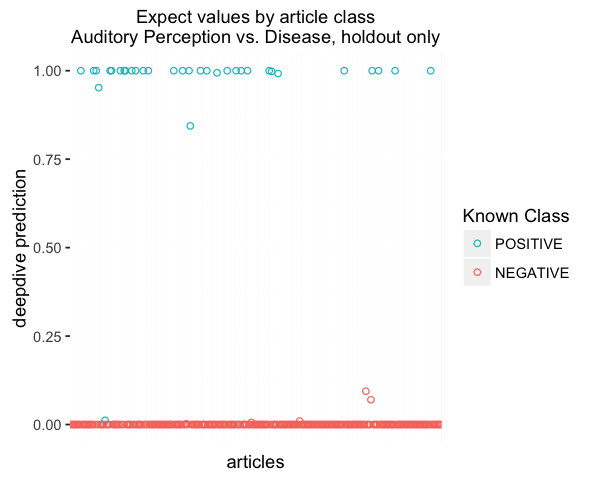

In [193]:
pdf('cc_expect_vs_known_holdout_only.pdf', height=4, width=4)
plot_expect_vs_known_t_f(test, 'index', 'expect', 'raw_has_terms', 'Auditory Perception vs. Disease')
dev.off()

plot_expect_vs_known_t_f(test, 'index', 'expect', 'raw_has_terms', 'Auditory Perception vs. Disease, holdout only')

## Training results

In [209]:
test_ids <- test$sentence_id
train <- t[is.na(t$test_has_term) & !is.na(t$raw_has_terms) & !t$sentence_id %in% test_ids,]
train <- train[!duplicated(train$sentence_id),]
nrow(train)
train$index <- row.names(train)

[1] 854

In [210]:
train_conf = get_confusion_matrix(train)
train_conf$table
train_conf$stats

          Reference
Prediction Negative Positive
  Negative      741        0
  Positive        0      113

Accuracy        AccuracyLower        AccuracyUpper 
           1.0000000            0.9956898            1.0000000 
         Sensitivity          Specificity       Pos Pred Value 
           1.0000000            1.0000000            1.0000000 
      Neg Pred Value           Prevalence       Detection Rate 
           1.0000000            0.1323185            0.1323185 
Detection Prevalence    Balanced Accuracy 
           0.1323185            1.0000000

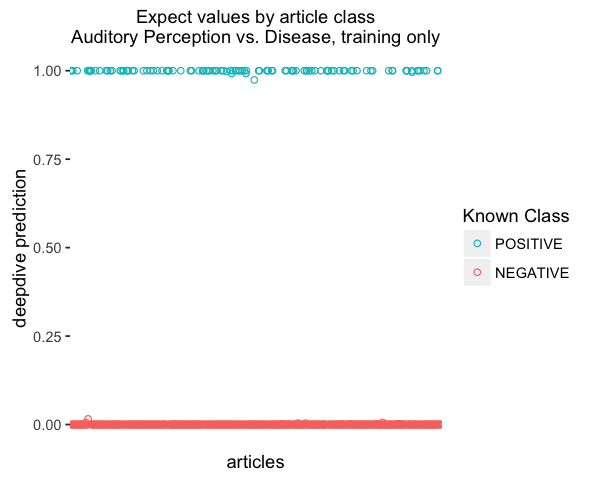

In [212]:
pdf('cc_expect_vs_known_train_only.pdf', height=4, width=4)
plot_expect_vs_known_t_f(train, 'index', 'expect', 'raw_has_terms', 'Auditory Perception vs. Disease')
dev.off()

plot_expect_vs_known_t_f(train, 'index', 'expect', 'raw_has_terms', 'Auditory Perception vs. Disease, training only')

## Auditory perception because they had that as MeSH term?
Even though we did not annotate them specifically, we presume these are likely True positives.

In [267]:
known_ids <- all_known$sentence_id
unknowns <- t[is.na(t$raw_has_terms) & !t$sentence_id %in% known_ids,]
unknowns <- unknowns[!duplicated(unknowns$sentence_id),]
nrow(unknowns)
unknowns$raw_has_terms <- 't'
unknowns$index <- row.names(unknowns)
head(unknowns)
df <- unknowns

[1] 988

test_has_term raw_has_terms sentence_id expect index
9           <NA>             t    20047084  0.002     9
14          <NA>             t    20236795  0.000    14
17          <NA>             t    20388591  0.996    17
22          <NA>             t    20447726  0.972    22
27          <NA>             t    20507830  0.074    27
34          <NA>             t    20557486  0.974    34

In [ ]:
#unknowns[unknowns$sentence_id == '20047084',]$raw_has_terms <- 'f'
conf = get_confusion_matrix(unknowns)
conf$table
conf$stats

pdf 
  2

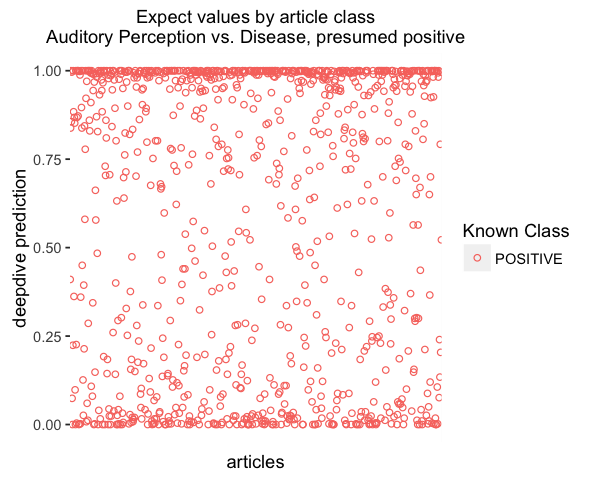

In [276]:
pdf('cc_expect_vs_known_presumed_positive.pdf', height=4, width=4)
plot_expect_vs_known_t_f(unknowns, 'index', 'expect', 'raw_has_terms', 'Auditory Perception vs. Disease')
dev.off()
plot_expect_vs_known_t_f(unknowns, 'index', 'expect', 'raw_has_terms', 'Auditory Perception vs. Disease, presumed positive')

# Appendix

## A.1 Some accounting shows we had duplicates in our input to deepdive.
### Get total counts and compare to expected class counts
We submitted scores to deepdive for true and false samples (raw_has_term column). 

### Data should correspond to raw_input counts in some way.
our tables should contain 3292 scores from the raw data + duplicates due either to deepdive or the sql join statement we used to generate input to the current notebook.(duplicates refer to sentence_id name.)

From our experience running DeepDive we know that our tables reported holdout fraction 2x, once as pseudo-unkown and once as knowns.

Further, we know deepdive does not separately report the training data, so it should only be in tables once, as pseudo-unkowns.

In [3]:
3292 + 33 + 259 + 33 + 259 == 3876

[1] TRUE

Compare to our full table used as input herein.

In [4]:
nrow(t)
# 3864
#
table(t$raw_has_term, useNA = "ifany")
#

#    f    t <NA> 
# 1259  191 2465 

[1] 3915


   f    t <NA> 
1259  191 2465 

We observe 3915 records herein from our sql table, 39 more than the 3876 expected

In [5]:
# input with labels
tr <- t[which(t$raw_has_terms == 't'),]
fa <- t[which(t$raw_has_terms == 'f'),]

length(table(tr$sentence_id))
length(table(fa$sentence_id))

# input without labels
na <- t[is.na(t$raw_has_terms),]
length(table(na$sentence_id))

[1] 146

[1] 1000

[1] 2134

Note we recover the full 146 labeled trues, the 1000 labeled falses. 

But 2146 should be the combined 1146 labeled as unlabeled + 1000 unlabeled because we don't konw their labels.

We are short by 12 records indicating an overlap between our 1000 input set and 1146 input set. Actually probably among the 146 inputs and the unknowns since the unknowns are also likely of the topic of interest.

### Examine the true class in more detail.
We expect 146 total, 113 that were used for training and 33 that were in the holdout. We observe 9 additional records in the training, due to overlap of our training with our unknowns.


In [6]:
t_and_holdout <- tr[which(tr$test_has_term == 't'),]$sentence_id
length(t_and_holdout)
length(unique(t_and_holdout))

t_and_training <- tr[which(!(tr$sentence_id %in% t_and_holdout)),]$sentence_id
length(t_and_training)
dups <- t_and_training[duplicated(t_and_training)]
dups
t[t$sentence_id == '21261633',] # ALL SIMILAR TO THIS.

t_and_training2 <- t[which(t$test_has_term == 't' & is.na(t$raw_has_terms)),]$sentence_id
length(t_and_training2)
dups <- t_and_training2[duplicated(t_and_training2)]
dups
t[t$sentence_id == '22773777',] # ALL SIMILAR TO THIS.

[1] 33

[1] 33

[1] 122

[1] 21261633 21368051 21387016 21483666 22280585 22384211 22786953 23308266
[9] 23585888

test_has_term raw_has_terms sentence_id expect
192          <NA>          <NA>    21261633      1
193          <NA>          <NA>    21261633      1
194          <NA>             t    21261633      1
195          <NA>             t    21261633      1
196          <NA>          <NA>    21261633      1
197          <NA>          <NA>    21261633      1

[1] 36

[1] 22773777 23716244 24423729

test_has_term raw_has_terms sentence_id expect
1466          <NA>          <NA>    22773777      1
1467             t          <NA>    22773777      1
1468             t          <NA>    22773777      1
1469          <NA>             t    22773777      1
1470          <NA>             t    22773777      1
1471             t             t    22773777      1
1472          <NA>          <NA>    22773777      1
1473          <NA>          <NA>    22773777      1
1474          <NA>          <NA>    22773777      1

To summarize, the overlap of 12 ids between the training and the unknowns resulted in:

9 ids that were also in the true labeled class and therefore predicted 1x as pseudolabeled uknown, and 1x as unknown.
3 ids that were as the above 9 except also predicted in the holdout.

### Confirming source of these duplicates in our input file to deepdive.

### Checking for duplicates amongst the other classes.
The duplicates among the NA class are likewise from these same 12 overlapping records.

In [21]:
table(table(fa$sentence_id) > 2)
table(table(na$sentence_id) > 2)
names(table(na$sentence_id))[table(na$sentence_id) > 2]


FALSE 
 1000 


FALSE  TRUE 
 2122    12 

[1] "21261633" "21368051" "21387016" "21483666" "22280585" "22384211"
 [7] "22773777" "22786953" "23308266" "23585888" "23716244" "24423729"

## A.2 Additional accounting shows that given the same sentence DeepDive sometimes makes different predictions.
Deepdive appears to sometimes make slightly different predictions of the same sentence. Since our 'known' sentences are duplicated as both 'known' and 'pseudo-unknown' we should see if their is a directional trend that might be associated with the size of the dataset being predicted.

The only duplicate predictions we ought to see are those in the holdout set that are also 'pseudo-unkown' encoded.

In [22]:
all_known <- unique(t[!is.na(t$raw_has_terms), !(names(t) %in% c('test_has_term'))])
nrow(all_known)

[1] 1158

We expected 1146, but got 1158. The difference is due to differences in the predictions of a few sentences when in holdout vs. as pseudo-unknown.

1158 from :
- 146 labeled positives we started with
- 1000 labeled negatives.
- 12 labeled (positive or negative) that get predicted slightly different when as holdout vs. as pseudo-labeled.

In [23]:
all_known <- all_known[order(all_known$sentence_id),]
dups <- duplicated(all_known$sentence_id)
table(dups)
# dups
# FALSE  TRUE 
#  1146    12 
dup_ids <- all_known[dups,]$sentence_id
table(dup_ids)

dups
FALSE  TRUE 
 1146    12 

dup_ids
20493828 20936300 21496186 22592306 22735387 23462484 23815257 23827717 
       1        1        1        1        1        1        1        1 
24513795 24736181 24821552 25051669 
       1        1        1        1 

In [24]:
all_known[all_known$sentence_id %in% dup_ids[0:2],]

raw_has_terms sentence_id expect
25              t    20493828  0.992
26              t    20493828  0.994
99              f    20936300  0.000
102             f    20936300  0.002

## A.3 Duplicates due to mismatch of scores when knowns are labeled vs. unlabeled don't appear to follow a particular trend.
Is there a random seed causing this issue? Is there a conditioning on the number of examples being predicted?

Plotting the holdout values as colors and the predictions as grey, we see there does not seem to be a trend. Sometimes the predictions (grey) are more central, sometimes more extreme.

In [25]:
library(ggplot2)
library(repr)
options(repr.plot.width=5, repr.plot.height=4)
t_d <- t[which(t$sentence_id %in% dup_ids & !is.na(t$raw_has_terms)),]
t_d[0:6,]

test_has_term raw_has_terms sentence_id expect
25           <NA>             t    20493828  0.992
26              t             t    20493828  0.994
99              f             f    20936300  0.000
102          <NA>             f    20936300  0.002
405             f             f    21496186  0.070
406          <NA>             f    21496186  0.048

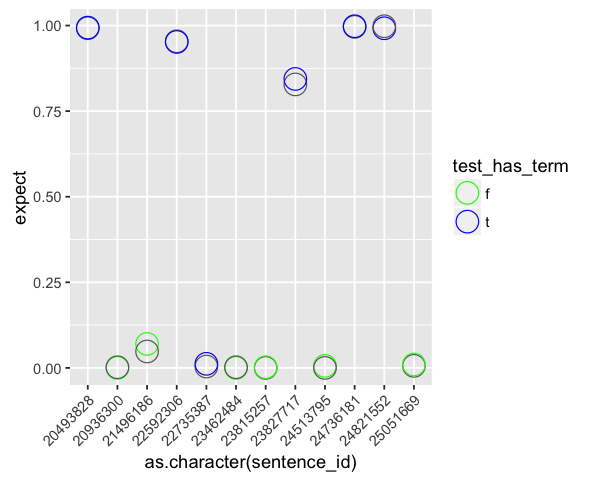

In [26]:
p <- ggplot(t_d, aes(x=as.character(sentence_id), y=expect, color=test_has_term)) +  geom_point(shape=1, size=6)
p + scale_color_manual(values=c('t'='blue', 'f'='green'), na.value='grey40') +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

### Note 22735387 is predicted negative, although TC labeled it positive for this topic.

The article does appear less related to the other positives.

Title:
'Association of Hemoglobin levels and Brainstem Auditory Evoked Responses in Lead-Exposed Children'

The abstract did seem to have more to due with disease and blood than about the psychology of auditory perception.

## A.4 Solution encoded as an RScript